In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, get_eb_p_value, eb_selector, psi_E, v_i, pm_lambda
np.random.seed(123456789)

In [2]:
stratum_1 = np.random.normal(loc = 0.5, scale = 0.05, size = 500)
stratum_2 = np.random.normal(loc = 0.6, scale = 0.05, size = 450)
stratum_3 = np.random.normal(loc = 0.2, scale = 0.05, size = 50)
strata = [stratum_1, stratum_2, stratum_3]
np.mean(np.concatenate(strata))

0.5292189963455255

In [3]:
log_mart, p_value, selected_strata, eta_star_mat, running_a, running_b = get_eb_p_value(strata = strata, gamma = 1)

/Users/Jake/Dropbox/RLAs/alpha/Code/utils.py:511: RuntimeWarning: divide by zero encountered in true_divide
  lam_pm = np.sqrt(2 * np.log(1/alpha) / (lag_sigma_hat**2 * j * np.log(1 + j)))


In [4]:
running_a

array([186.04279515, 198.97841243,   4.74178528])

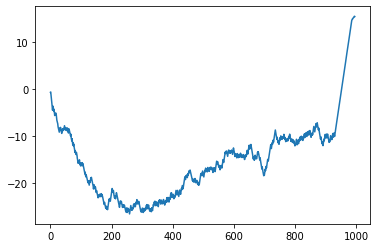

In [5]:
plt.plot(log_mart)

In [15]:
gamma = 0
run_in = 10
lam = None
N = np.array([len(x) for x in strata])
K = len(strata)
w = N/np.sum(N)
u = 1
marts = [np.ones(x) for x in N]
if lam is None:
    lam = [pm_lambda(stratum) for stratum in strata]
else:
    lam = [np.repeat(lam[k], N[k]) for k in np.arange(K)]
a = [np.cumsum(lam[k]*strata[k] - psi_E(lam[k])*v_i(strata[k])) for k in np.arange(K)]
running_n = np.zeros(K)
running_a = np.zeros(K)
running_b = np.zeros(K)
running_lam = np.array([x[0] for x in lam])
#record which strata are pulled from
selected_strata = np.zeros(np.sum(N) - K)
log_mart = np.zeros(np.sum(N) - K)
eta_star_mat = np.zeros((np.sum(N) - K, K))
i = 0
while any(running_n < (N-1)):
    next_stratum = eb_selector(running_a = running_a, running_n = running_n, running_b = running_b, run_in = run_in, N = N, gamma = gamma)
    selected_strata[i] = next_stratum
    running_n[next_stratum] += 1
    running_lam[next_stratum] = lam[next_stratum][int(running_n[next_stratum])]
    running_a[next_stratum] = a[next_stratum][int(running_n[next_stratum])]
    running_b[next_stratum] -= running_lam[next_stratum]
    eta_star = np.zeros(K)
    active = np.ones(K)
    #greedy algorithm to optimize over eta
    while((np.dot(eta_star, w) < 1/2) and all(eta_star <= u)):
        weight = -running_b / w
        max_index = np.argmax(weight * active)
        active[max_index] = 0
        eta_star[max_index] = np.minimum(u, (1/2 - np.dot(eta_star, w)) / w[max_index])
    log_mart[i] = np.sum(running_a) + np.dot(running_b, eta_star)
    eta_star_mat[i,:] = eta_star
    i += 1
    print(w/running_b / np.sum(w/running_b), running_n, eta_star)
    #print(running_b, running_n)
mart = np.exp(log_mart)
p_value = 1/np.maximum(1, mart)

[nan nan -0.] [0. 0. 1.] [0.9 0.  1. ]
[nan -0. -0.] [0. 1. 1.] [0. 1. 1.]
[nan -0. -0.] [0. 2. 1.] [0. 1. 1.]
[nan -0. -0.] [0. 2. 2.] [0. 1. 1.]
[nan -0. -0.] [0. 3. 2.] [0. 1. 1.]
[0.74074074 0.22222222 0.03703704] [1. 3. 2.] [0. 1. 1.]
[0.78431373 0.17647059 0.03921569] [1. 4. 2.] [0. 1. 1.]
[0.81300813 0.14634146 0.04065041] [1. 5. 2.] [0. 1. 1.]
[0.82417582 0.14835165 0.02747253] [1. 5. 3.] [0. 1. 1.]
[0.82987552 0.14937759 0.02074689] [1. 5. 4.] [0. 1. 1.]
[0.70921986 0.25531915 0.03546099] [2. 5. 4.] [0. 1. 1.]
[0.61919505 0.33436533 0.04643963] [3. 5. 4.] [0. 1. 1.]
[0.6557377  0.29508197 0.04918033] [3. 6. 4.] [0. 1. 1.]
[0.58823529 0.35294118 0.05882353] [4. 6. 4.] [0. 1. 1.]
[0.61946903 0.31858407 0.0619469 ] [4. 7. 4.] [0. 1. 1.]
[0.64516129 0.29032258 0.06451613] [4. 8. 4.] [0. 1. 1.]
[0.66666667 0.26666667 0.06666667] [4. 9. 4.] [0. 1. 1.]
[0.61538462 0.30769231 0.07692308] [5. 9. 4.] [0. 1. 1.]
[0.625  0.3125 0.0625] [5. 9. 5.] [0. 1. 1.]
[0.58139535 0.34883721 0.069767

/var/folders/zt/byjw_s1s4g5b01_cjmqw49480000gn/T/ipykernel_2760/867558519.py:41: RuntimeWarning: divide by zero encountered in true_divide
  print(w/running_b / np.sum(w/running_b), running_n, eta_star)
/var/folders/zt/byjw_s1s4g5b01_cjmqw49480000gn/T/ipykernel_2760/867558519.py:41: RuntimeWarning: invalid value encountered in true_divide
  print(w/running_b / np.sum(w/running_b), running_n, eta_star)
